In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
#Install Spark
!wget -q http://www.gtlib.gatech.edu/pub/apache/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
#Unzip the spark package
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz

spark-3.0.1-bin-hadoop2.7/
spark-3.0.1-bin-hadoop2.7/RELEASE
spark-3.0.1-bin-hadoop2.7/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/
spark-3.0.1-bin-hadoop2.7/examples/src/main/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop2.7/example

In [ ]:
#Installing findspark to spark initiation
!pip install -q findspark

In [ ]:
#Set Java and spark home environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

import pyspark
from pyspark.sql import SQLContext

#Creating spark context
# sc = pyspark.SparkContext(appName='IDS561 Project')
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
#path = "/content/drive/My Drive/ids561/project/"
path = "/content/drive/MyDrive/Fall2020/IDS561/Project/"
# path = "/content/drive/Shareddrives/IDS 561/archive/"

#importing data as spark dataframe
sqlContext = SQLContext(sc)
ratings_df = sqlContext.read.format('csv').option("header", "true").load(path + "ratings.csv")
links_df = sqlContext.read.format('csv').option("header", "true").load(path + "links.csv")

In [ ]:
#import movies data as pd and converted to sqlContext as it datatype mistamatch and data spill across columns
import pandas as pd
df = pd.read_csv(path+"movies_metadata.csv")
#df = pd.read_csv(path+"movies_data.csv")
int_df = df.astype(str)
movies_df = sqlContext.createDataFrame(int_df)
movies_df.show(10)
movies_df1=movies_df.select("title","overview")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+------------+-----------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|        popularity|         poster_path|production_companies|production_countries|release_date|    revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+------------+-

In [ ]:
import pyspark.sql.functions as F

# selecting specific columns in ratings
ratings_df =ratings_df.select('userId',"movieId","rating")
ratings_final_df = ratings_df.withColumn("userId", F.col("userId").cast('int')).withColumn("rating", F.col("rating").cast('float')).withColumn("movieId", F.col("movieId").cast('int'))

#selecting specific columns in movies dataset
movies = movies_df.select("genres","id","imdb_id", "original_title","popularity", "release_date","revenue","original_language","vote_average","vote_count")
movies_final_df = movies.withColumn("id", F.col("id").cast('int')).withColumn("id", F.col("id").cast('int')).withColumn("popularity", F.col("popularity").cast('float')).withColumn("revenue", F.col("revenue").cast('int')).withColumn("vote_average", F.col("vote_average").cast('float')).withColumn("vote_count", F.col("vote_count").cast('float'))


# Add movieId column to movies, join using tmdbId
import pyspark.sql.functions as F
movies_links= movies_final_df.join(links_df, movies_final_df.id == links_df.tmdbId, how = 'left').drop('tmdbId')
movies_links = movies_links.withColumn("movieId", F.col("movieId").cast('int'))
movie_ratings = ratings_final_df.join(movies_links, movies_links.movieId == ratings_final_df.movieId, how='Left').drop(ratings_final_df.movieId)


In [ ]:
movies_links.show(2)

+--------------------+----+---------+--------------+----------+------------+---------+-----------------+------------+----------+-------+-------+
|              genres|  id|  imdb_id|original_title|popularity|release_date|  revenue|original_language|vote_average|vote_count|movieId| imdbId|
+--------------------+----+---------+--------------+----------+------------+---------+-----------------+------------+----------+-------+-------+
|[{'id': 16, 'name...| 862|tt0114709|     Toy Story| 21.946943|  1995-10-30|373554033|               en|         7.7|    5415.0|      1|0114709|
|[{'id': 12, 'name...|8844|tt0113497|       Jumanji|  17.01554|  1995-12-15|262797249|               en|         6.9|    2413.0|      2|0113497|
+--------------------+----+---------+--------------+----------+------------+---------+-----------------+------------+----------+-------+-------+
only showing top 2 rows



In [ ]:
movie_ratings.show(10)

+------+------+--------------------+-----+---------+--------------------+----------+------------+-------+-----------------+------------+----------+-------+-------+
|userId|rating|              genres|   id|  imdb_id|      original_title|popularity|release_date|revenue|original_language|vote_average|vote_count|movieId| imdbId|
+------+------+--------------------+-----+---------+--------------------+----------+------------+-------+-----------------+------------+----------+-------+-------+
|   337|   4.0|[{'id': 10749, 'n...|22279|tt0112427|An Awfully Big Ad...|  0.922958|  1995-07-21| 851545|               en|         6.0|      11.0|    148|0112427|
|   619|   2.0|[{'id': 10749, 'n...|22279|tt0112427|An Awfully Big Ad...|  0.922958|  1995-07-21| 851545|               en|         6.0|      11.0|    148|0112427|
|  3030|   4.0|[{'id': 10749, 'n...|22279|tt0112427|An Awfully Big Ad...|  0.922958|  1995-07-21| 851545|               en|         6.0|      11.0|    148|0112427|
|  5261|   3.0|[

###Exploratory Data Analysis

In [ ]:
## Transform Date column for analysis
import datetime
def transformDate(dateStr):
  try:
      datetime.datetime.strptime(dateStr, '%Y-%m-%d')
      return (dateStr[:4])
  except ValueError:
      return None

movies_rdd1=movie_ratings.rdd.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],transformDate(x[7]),x[8],x[9],x[10],x[11],x[12],x[13]))

In [ ]:
movies_rdd1.take(1)

[(337,
  4.0,
  "[{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]",
  22279,
  'tt0112427',
  'An Awfully Big Adventure',
  0.9229580163955688,
  '1995',
  851545,
  'en',
  6.0,
  11.0,
  148,
  '0112427')]

In [ ]:
# Transform Genre from Json object to list of genres

def transform_genre(gen):
  import json
  genre=[]
  try:
    res=json.loads(gen.replace("'", '"'))
    # print(res)
    for j in res:
      # print(j["name"])
      genre.append(j["name"])
    return genre
  except:
    return ""

# print(type(transform_genre("[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]")))

movies_rdd2=movies_rdd1.map(lambda x: (x[0],x[1],transform_genre(x[2]),x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13]))

In [ ]:
movies_rdd2.take(2)

[(337,
  4.0,
  ['Romance', 'Drama', 'Comedy'],
  22279,
  'tt0112427',
  'An Awfully Big Adventure',
  0.9229580163955688,
  '1995',
  851545,
  'en',
  6.0,
  11.0,
  148,
  '0112427'),
 (619,
  2.0,
  ['Romance', 'Drama', 'Comedy'],
  22279,
  'tt0112427',
  'An Awfully Big Adventure',
  0.9229580163955688,
  '1995',
  851545,
  'en',
  6.0,
  11.0,
  148,
  '0112427')]

In [ ]:
# univariate analysis
import json
genre=[]
mov_genre=movies.na.drop(how='any',subset=['genres','id','imdb_id','vote_average','vote_count']).select("genres").rdd.collect()
for i in mov_genre:
  try:
    res=json.loads(i[0].replace("'", '"'))
    for j in res:
      genre.append(j)
  except:
    continue

In [ ]:
genre_types={}
for i in genre:
  if i["name"] in genre_types:
    genre_types[i["name"]]+=1
  else:
    genre_types[i["name"]]=1
  

In [ ]:
print(genre_types)

{'Animation': 1935, 'Comedy': 13182, 'Family': 2770, 'Adventure': 3496, 'Fantasy': 2313, 'Romance': 6735, 'Drama': 20265, 'Action': 6596, 'Crime': 4307, 'Thriller': 7624, 'Horror': 4673, 'History': 1398, 'Science Fiction': 3049, 'Mystery': 2467, 'War': 1323, 'Foreign': 1622, 'Music': 1598, 'Documentary': 3932, 'Western': 1042, 'TV Movie': 767, 'Carousel Productions': 1, 'Vision View Entertainment': 1, 'Telescene Film Group Productions': 1, 'Aniplex': 1, 'GoHands': 1, 'BROSTA TV': 1, 'Mardock Scramble Production Committee': 1, 'Sentai Filmworks': 1, 'Odyssey Media': 1, 'Pulser Productions': 1, 'Rogue State': 1, 'The Cartel': 1}


In [ ]:
#ploting the genres types
import plotly.graph_objects as go
fig = go.Figure(go.Bar(
            x=tuple(genre_types.values()),
            y=tuple(genre_types.keys()),
            orientation='h'))

fig.show()


In [ ]:
movies_links.show(2)

+--------------------+----+---------+--------------+----------+------------+---------+-----------------+------------+----------+-------+-------+
|              genres|  id|  imdb_id|original_title|popularity|release_date|  revenue|original_language|vote_average|vote_count|movieId| imdbId|
+--------------------+----+---------+--------------+----------+------------+---------+-----------------+------------+----------+-------+-------+
|[{'id': 16, 'name...| 862|tt0114709|     Toy Story| 21.946943|  1995-10-30|373554033|               en|         7.7|    5415.0|      1|0114709|
|[{'id': 12, 'name...|8844|tt0113497|       Jumanji|  17.01554|  1995-12-15|262797249|               en|         6.9|    2413.0|      2|0113497|
+--------------------+----+---------+--------------+----------+------------+---------+-----------------+------------+----------+-------+-------+
only showing top 2 rows



In [ ]:
## tranform genre for movies_final_df to use in recommendation
rdd_inter = movies_links.rdd.map(list)
movies_rdd3=rdd_inter.map(lambda x: (transform_genre(x[0]),x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9], x[10],x[11]))
movies_rdd3.take(2)

movies_links_final_df = sqlContext.createDataFrame(movies_rdd3)


In [ ]:
movies_links_final_df.show(2)

+--------------------+----+---------+---------+------------------+----------+---------+---+-----------------+------+---+-------+
|                  _1|  _2|       _3|       _4|                _5|        _6|       _7| _8|               _9|   _10|_11|    _12|
+--------------------+----+---------+---------+------------------+----------+---------+---+-----------------+------+---+-------+
|[Animation, Comed...| 862|tt0114709|Toy Story|21.946943283081055|1995-10-30|373554033| en|7.699999809265137|5415.0|  1|0114709|
|[Adventure, Fanta...|8844|tt0113497|  Jumanji|17.015539169311523|1995-12-15|262797249| en|6.900000095367432|2413.0|  2|0113497|
+--------------------+----+---------+---------+------------------+----------+---------+---+-----------------+------+---+-------+
only showing top 2 rows



In [ ]:
### Final Ratings and movies

ratings_final_df
movies_links_final_df = movies_links_final_df.withColumnRenamed("_1","Genre").withColumnRenamed("_2","id").withColumnRenamed("_3","imdb_id").withColumnRenamed("_4","original_title").withColumnRenamed("_5","popularity").withColumnRenamed("_6","release_date").withColumnRenamed("_7","revenue").withColumnRenamed("_8","original_language").withColumnRenamed("_9","vote_average").withColumnRenamed("_10","vote_count").withColumnRenamed("_11","movieId").withColumnRenamed("_12","imdbId")
movies_links_final_df.show(2)

+--------------------+----+---------+--------------+------------------+------------+---------+-----------------+-----------------+----------+-------+-------+
|               Genre|  id|  imdb_id|original_title|        popularity|release_date|  revenue|original_language|     vote_average|vote_count|movieId| imdbId|
+--------------------+----+---------+--------------+------------------+------------+---------+-----------------+-----------------+----------+-------+-------+
|[Animation, Comed...| 862|tt0114709|     Toy Story|21.946943283081055|  1995-10-30|373554033|               en|7.699999809265137|    5415.0|      1|0114709|
|[Adventure, Fanta...|8844|tt0113497|       Jumanji|17.015539169311523|  1995-12-15|262797249|               en|6.900000095367432|    2413.0|      2|0113497|
+--------------------+----+---------+--------------+------------------+------------+---------+-----------------+-----------------+----------+-------+-------+
only showing top 2 rows



In [ ]:
#Calculate Sparsity of our matrix
num_users =ratings_final_df.select("userId").distinct().count()
num_movies = ratings_final_df.select("movieId").distinct().count()
num_ratings = ratings_final_df.select("rating").count()

Sparsity_perc = (1- num_ratings/(num_users*num_movies))
Sparsity_perc

0.9978706094662383

In [ ]:
df['title'] = df['title'].astype('str')
title1= ' '.join(df['title'])

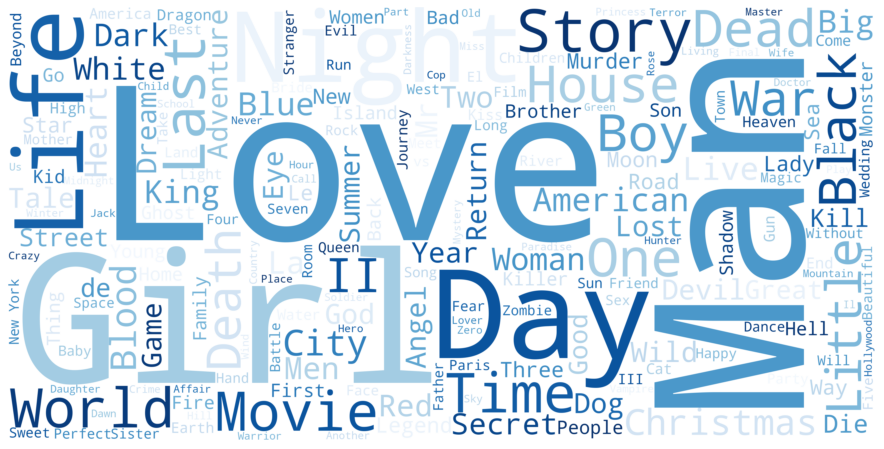

In [ ]:
#Creating word cloud for movie title for insights of most occuring words in movie title and inference the genre types
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000,colormap="Blues").generate(title1)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
#Love and Girl or most occured and can inference there are more drama genre

## Simple recommender

In [ ]:
# IMDB weighted average formula 
def weighted_rating(x,m,C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
#Compute top_movies for given genre based on the vote count and vote average 
def top_movies(genre, percentile=0.85):
    df1 = df[df.genres.astype(str).str.contains(genre)]
    vote_counts = df1[df1['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df1[df1['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    selected = df1[(df1['vote_count'] >= m) & (df1['vote_count'].notnull()) & (df1['vote_average'].notnull())][['title', 'release_date', 'vote_count', 'vote_average', 'popularity']]
    selected['vote_count'] = selected['vote_count'].astype('int')
    selected['vote_average'] = selected['vote_average'].astype('int')
    selected['wr'] = weighted_rating(selected,m,C)
    selected = selected.sort_values('wr', ascending=False).head(250)
    return df1

In [ ]:
top_movies_list=top_movies("Drama",0.85)['original_title']
top_movies_list.head(15)

3          Waiting to Exhale
5                       Heat
7               Tom and Huck
10    The American President
13                     Nixon
15                    Casino
16     Sense and Sensibility
21                   Copycat
23                    Powder
24         Leaving Las Vegas
25                   Othello
26              Now and Then
27                Persuasion
29                 摇啊摇，摇到外婆桥
30           Dangerous Minds
Name: original_title, dtype: object

In [ ]:
top_movies_list.head(15).to_csv('Simple_recommender.csv')

Splitting the dataset into Train and Test set

In [ ]:
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(training_set, test_set) = ratings_final_df.randomSplit([0.7, 0.3], seed=1234)

# Naive Baseline

In [ ]:
##Baseline - Naive Method

default_value = training_set.agg(F.avg('rating')).collect()[0][0]
print(default_value)


#### Adding avg rating in test dataset 
test_for_avg_df = test_set.withColumn('prediction', F.lit(default_value))
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="rating", metricName="rmse")

# Run the previously created RMSE evaluator, reg_eval, on the test_for_avg_df DataFrame
test_avg_RMSE = reg_eval.evaluate(test_for_avg_df)
  
print("The RMSE on the average set is {0}".format(test_avg_RMSE)) 


3.5280432637271977
The RMSE on the average set is 1.0652637513844136


The average rating is 3.5280 for all movies. This is the naive method where average is considered for all users to have given a rating on 3.52 for all movies. The RMSE on the average set is 1.0652. The RMSE of our algorithms should be lower than this baseline.

# ALS - Alternative Least Squares

In [ ]:
## ALS

als_mod = ALS(userCol="userId", itemCol = "movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

#Tuning the model with ParamGridBuilder

#paramGrid = ParamGridBuilder().addGrid(als_mod.rank, [10,15,5]).addGrid(als_mod.maxIter, [15,10]).addGrid(als_mod.regParam, [.01,.5,.1]).build()#Tuning the model with ParamGridBuilder
#Tuning the model with ParamGridBuilder

paramGrid = ParamGridBuilder().addGrid(als_mod.rank, [15]).addGrid(als_mod.maxIter, [15]).addGrid(als_mod.regParam, [.1]).build()

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

#Cross validation

cv_als = CrossValidator(estimator=als_mod, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

model_als = cv_als.fit(training_set)

# determine best model from the grid
Best = model_als.bestModel

pred = Best.transform(test_set)
rmse = evaluator.evaluate(pred)

print("Root-mean-square error = " + str(rmse))
print("Best Model = ")
print("Rank = "), Best.rank
print("MaxIter:"),Best._java_obj.parent().getMaxIter()
print("RegParam:"),Best._java_obj.parent().getRegParam()

Root-mean-square error = 0.8184051986361045
Best Model = 
Rank = 
MaxIter:
RegParam:


(None, 0.1)

In [ ]:
output= pred.select("*").sort("UserId","rating")
output.show(10)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     1|  98809|   0.5| 4.1887918|
|     1|    110|   1.0| 4.2940497|
|     1|  99114|   4.0|  4.365529|
|     1|    147|   4.5| 4.0326567|
|     1|  91542|   5.0|  4.148851|
|     1| 112552|   5.0| 4.6289835|
|     1|   1246|   5.0| 4.5745454|
|     2|     32|   2.0| 3.3713336|
|     2|   1475|   3.0|  3.046525|
|     2|      5|   3.0|  2.825674|
+------+-------+------+----------+
only showing top 10 rows



In [ ]:
# Generate top 10 movies recommendations for a user
users = ratings_final_df.select(als_mod.getUserCol()).distinct().limit(20)
userSubsetRecs = Best.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of movies
movies = ratings_final_df.select(als_mod.getItemCol()).distinct().limit(20)
movieSubSetRecs = Best.recommendForItemSubset(movies, 10)


In [ ]:
movieSubSetRecs.show(10)

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|   1580|[[252930, 5.73782...|
|   6620|[[102545, 5.27151...|
|    471|[[102545, 5.26253...|
|   1591|[[252930, 4.91016...|
|   1342|[[125672, 5.17711...|
|   2122|[[125672, 5.17177...|
|   2142|[[218260, 5.11559...|
|   3794|[[118022, 4.87964...|
|   1645|[[252930, 5.57585...|
|   3175|[[252930, 5.50927...|
+-------+--------------------+
only showing top 10 rows



In [ ]:
movies_links_final_df.head()

Row(Genre=['Animation', 'Comedy', 'Family'], id=862, imdb_id='tt0114709', original_title='Toy Story', popularity=21.946943283081055, release_date='1995-10-30', revenue=373554033, original_language='en', vote_average=7.699999809265137, vote_count=5415.0, movieId=1, imdbId='0114709')

In [ ]:

# user rec for a movie
onemovie_rec = movieSubSetRecs.where("movieId == 1591").limit(1)

recs = onemovie_rec.select("recommendations.userId","recommendations.rating")
users = recs.select("userId").toPandas().iloc[0,0]
ratings = recs.select("rating").toPandas().iloc[0,0]
rating_mat = pd.DataFrame(users, columns=["userId"])
rating_mat["ratings"]= ratings
rating_matrix_movie = sqlContext.createDataFrame(rating_mat)

# Join with ratings and print

Joined_movie_recs = rating_matrix_movie.join(movies_links_final_df, movies_links_final_df.movieId == 1591, how='Left')
df4 = Joined_movie_recs.select("userId","ratings","Genre","original_title")
df4.show()



+------+------------------+--------------------+--------------+
|userId|           ratings|               Genre|original_title|
+------+------------------+--------------------+--------------+
|252930| 4.910168647766113|[Action, Adventur...|         Spawn|
| 51433| 4.753296852111816|[Action, Adventur...|         Spawn|
| 24298| 4.740478038787842|[Action, Adventur...|         Spawn|
|146018| 4.723087310791016|[Action, Adventur...|         Spawn|
| 48771|  4.71718692779541|[Action, Adventur...|         Spawn|
|111340| 4.711960315704346|[Action, Adventur...|         Spawn|
|204309| 4.686577320098877|[Action, Adventur...|         Spawn|
|133816|  4.67604923248291|[Action, Adventur...|         Spawn|
|221507| 4.671408176422119|[Action, Adventur...|         Spawn|
| 12002|4.6673736572265625|[Action, Adventur...|         Spawn|
+------+------------------+--------------------+--------------+



The above users are recommended for this movie. To check the actual ratings of other movies by one user, we consider user:40980

In [ ]:

df2 =movie_ratings.select("userId","rating","genres","original_title","movieId").where("userId ==40980")
rdd5 = df2.rdd.map(list)
rdd5 = rdd5.map(lambda x: (x[0], x[1],transform_genre(x[2]), x[3], x[4]))

df2 = sqlContext.createDataFrame(rdd5)

df2 = df2.withColumnRenamed("_1","userId").withColumnRenamed("_2","rating").withColumnRenamed("_3","Genre").withColumnRenamed("_4","original_title").withColumnRenamed("_5","movie_id")
df2.show()

+------+------+--------------------+--------------------+--------+
|userId|rating|               Genre|      original_title|movie_id|
+------+------+--------------------+--------------------+--------+
| 40980|   5.0|[Action, Adventur...|               Spawn|    1591|
| 40980|   5.0|    [Comedy, Family]|       That Darn Cat|    1460|
| 40980|   5.0|[Drama, Romance, ...| The English Patient|    1183|
| 40980|   5.0|[Adventure, Comed...|George of the Jungle|    1588|
| 40980|   5.0|[Science Fiction,...|               Steel|    1599|
| 40980|   5.0|         [Adventure]|Free Willy 3: The...|    1595|
| 40980|   3.0|  [Action, Thriller]|       Air Force One|    1608|
| 40980|   3.0|[Action, Crime, D...|            Cop Land|    1589|
| 40980|   4.0|[Action, Adventur...|       Fly Away Home|     986|
| 40980|   2.0|            [Comedy]|              Mother|    1414|
| 40980|   5.0|[Crime, Drama, Th...|       Keys to Tulsa|    1501|
| 40980|   5.0|[Adventure, Comed...|  Leave it to Beaver|    1

We see that the output is valid, as the user likes the action, adventure movies and has rated them 5.

In [ ]:
userSubsetRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|  1580|[[140323, 4.69432...|
|   471|[[120134, 5.73319...|
|  1591|[[164937, 6.55594...|
|  1342|[[140024, 4.81964...|
|  2122|[[163553, 6.24888...|
|  2142|[[173153, 6.05634...|
|   463|[[142891, 4.06828...|
|   833|[[173153, 5.79673...|
|  1645|[[81117, 5.024770...|
|  3175|[[120134, 5.64345...|
|   496|[[164937, 5.97054...|
|  2366|[[171275, 5.10488...|
|  2866|[[172777, 5.97738...|
|   148|[[151989, 5.23835...|
|  1088|[[172777, 6.79329...|
|  1238|[[151989, 4.72734...|
|  1829|[[171275, 6.27829...|
|  1959|[[163126, 4.30863...|
|  2659|[[151989, 5.94577...|
|  3749|[[164937, 5.02350...|
+------+--------------------+



In [ ]:
# movie rec for user
oneuser_rec =userSubsetRecs.where("userId == 1238").limit(1)
#oneuser_rec.show()

recs = oneuser_rec.select("recommendations.movieId","recommendations.rating")
movies = recs.select("movieId").toPandas().iloc[0,0]
ratings = recs.select("rating").toPandas().iloc[0,0]
rating_mat = pd.DataFrame(movies, columns=["movieId"])
rating_mat["ratings"]= ratings
rating_matrix = sqlContext.createDataFrame(rating_mat)

Joined_user_recs = rating_matrix.join(movies_links_final_df, movies_links_final_df.movieId == rating_matrix.movieId, how='Left').drop(movies_links_final_df.movieId)
#Joined_user_recs.show()

Joined_user_recs.select("movieId","ratings","Genre","original_title").show(10)

+-------+------------------+--------------------+--------------------+
|movieId|           ratings|               Genre|      original_title|
+-------+------------------+--------------------+--------------------+
| 144202|4.4879631996154785|    [Action, Family]|         Klatretøsen|
| 101706| 4.438248157501221|             [Drama]|           Lush Life|
| 120134|4.6600422859191895|                null|                null|
| 164061| 4.367250919342041|    [Romance, Drama]|La ragazza del mondo|
| 143422| 4.391817569732666|             [Drama]|                   2|
| 142891|  4.67064094543457|    [Drama, Romance]|Die Legende von P...|
|  81117| 4.514476776123047|                  []|                 Cma|
| 165689| 4.349762916564941|[Horror, Mystery,...|         Head Trauma|
| 150228|  4.52349328994751|       [Documentary]|Inner Worlds, Out...|
| 151989|4.7273430824279785|            [Comedy]|           The Thorn|
+-------+------------------+--------------------+--------------------+



Above are the recommendations of movies to the user 1238. Checking that user's actaul ratings and genres. It does seem valid.

In [ ]:


df1 =movie_ratings.select("movieId","rating","genres","original_title").where("userId==1238")
rdd4 = df1.rdd.map(list)
rdd4 = rdd4.map(lambda x: (x[0], x[1],transform_genre(x[2]), x[3]))

df1 = sqlContext.createDataFrame(rdd4)

df1 = df1.withColumnRenamed("_1","movieId").withColumnRenamed("_2","rating").withColumnRenamed("_3","Genre").withColumnRenamed("_4","original_title")
df1.show()

+-------+------+--------------------+--------------------+
|movieId|rating|               Genre|      original_title|
+-------+------+--------------------+--------------------+
|    858|   5.0|      [Drama, Crime]|       The Godfather|
|  48780|   4.0|[Drama, Mystery, ...|        The Prestige|
|   2231|   4.0|      [Drama, Crime]|            Rounders|
|   5995|   3.0|        [Drama, War]|         The Pianist|
|    296|   5.0|   [Thriller, Crime]|        Pulp Fiction|
|  41285|   4.5|[Drama, Thriller,...|         Match Point|
|  68954|   2.5|[Animation, Comed...|                  Up|
|  58559|   3.5|[Drama, Action, C...|     The Dark Knight|
|    593|   5.0|[Crime, Drama, Th...|The Silence of th...|
|  71033|   3.5|[Crime, Drama, My...|El secreto de sus...|
|  60950|   3.5|    [Drama, Romance]|Vicky Cristina Ba...|
|   6993|   3.5|     [Comedy, Drama]|Hannah and Her Si...|
|   1244|   3.5|[Comedy, Drama, R...|           Manhattan|
|    665|   5.0|[War, Drama, Comedy]|           Podzemlj

Exporting to excel to input into tableau

In [ ]:
import pandas
df4.toPandas().to_csv('Predicted_user.csv')
df2.toPandas().to_csv('Actual_user.csv')

In [ ]:
Joined_user_recs.toPandas().to_csv('predicted_movies.csv')
df1.toPandas().to_csv('Actual_movies.csv')
